In [524]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

experiments.2Q_state_tomography
experiments.amplitude_rabi
experiments.amplitude_rabi_ef
experiments.amplitude_rabi_EgGf
experiments.clifford_averager_program
experiments.length_rabi
experiments.pulse_probe_ef_spectroscopy
experiments.pulse_probe_spectroscopy
experiments.ramsey_ef
experiments.randbench
experiments.resonator_spectroscopy
experiments.rfsoc_tof_calibration
experiments.single_shot
experiments.t1
experiments.t2_echo
experiments.t2_ramsey


In [3]:
expt_path=os.getcwd()+'\data'
print('Data will be stored in', expt_path)
config_path = os.getcwd() + '\config.yml'
print('Config will be', config_path)

Data will be stored in s:\Connie\experiments\slab_rfsoc_expts\data
Config will be s:\Connie\experiments\slab_rfsoc_expts\config.yml


In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
    return temp_data

In [5]:
qubits = [0, 1] # which qubit/resonator we want to probe

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [6]:
import yaml
with open('config.yml', 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)

In [7]:
im = InstrumentManager()

In [ ]:
lo1 = im[yaml_cfg['aliases']['readout_LO']]
lo1.open_device()
# lo1.set_standby(True)
# lo1.set_output_state(False) # TURN ON/OFF
lo1.set_standby(False)
lo1.set_output_state(True) # TURN ON/OFF

lo1.set_frequency(float(yaml_cfg['hw']['lo']['readout']['frequency'])) # Set LO frequency
lo1.set_power(float(yaml_cfg['hw']['lo']['readout']['power'])) # Set LO power

0

In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
# print(soc.description())
# print(soc.dump_cfg())

# Begin state tomography

Measurement occurs along 9 axes, each of which can give one of 4 values:

ZZ, ZX, ZY, XZ, XX, XY, YZ, YX, YY -> {00, 01, 10, 11}

## Run the experiment

Run experiment and acquire data

In [84]:
tomo = meas.EgGfStateTomographyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"EgGf_state_tomo_{qubits[0]}{qubits[1]}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=10, # reps per measurement basis
    qubits=qubits,
)

print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [130, 45], 'f_ge': [3672.7788, 4565.7], 'f_ef': [3513.592, 4387.126], 'f_EgGf': 5245.152, 'pulses': {'pi_ge': {'gain': [20522, 2012], 'sigma': [0.1, 0.05], 'type': 'gauss'}, 'pi_ef': {'gain': [7195, 1590], 'sigma': [0.3, 0.05], 'type': 'gauss'}, 'pi_EgGf': {'gain': 20439, 'sigma': 1, 'type': 'gauss'}}}, 'readout': {'lo': ['readout', 'readout'], 'trig_offset': 250, 'frequency': [299.6865, 899.6655], 'gain': [60, 120], 'phase': [0, 0.49892147931760106], 'threshold': [0, 0], 'readout_length': [10, 10], 'relax_delay': [600, 200]}}, 'hw': {'lo': {'readout': {'frequency': '6.25e9', 'power': 16}}, 'soc': {'adcs': {'readout': {'ch': [0, 1]}}, 'dacs': {'qubit': {'ch': [4, 5], 'nyquist': [2, 2]}, 'readout': {'ch': [1, 2], 'nyquist': [1, 1]}}}}, 'aliases': {'readout_LO': 'SC26C3', 'soc': 'Qick187'}, 'expt': {'reps': 10, 'qubits': [0, 1]}}


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [102]:
# separate out the data from the tomography measurements and the confusion matrix calibration
n_tomo = tomo.data['counts_tomo']
n_calib = tomo.data['counts_calib']

In [87]:
measurement_order = tomo.data['meas_order']
calib_order = tomo.data['calib_order']

## Get initial rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [74]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S12): # given 2 pauli matrix names, get the index at which that combo (or equivalent data) was measured
    assert S12[0] in 'IXYZ'
    assert S12[1] in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S12[0] == 'I': S12 = 'Z'+S12[1]
    if S12[1] == 'I': S12 = S12[0]+'Z'
    return np.argwhere(measurement_order == S12)[0][0]
# print(order('II'))

In [ ]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = [] # ordered in the same sequence as the n counts array (36 elements)
for S12 in measurement_order:
    S1, S2 = S12
    psi1 = psi[S1]
    psi2 = psi[S2]
    psi_basis.append(qt.tensor(psi1[0], psi2[0])) # gg
    psi_basis.append(qt.tensor(psi1[0], psi2[1])) # ge
    psi_basis.append(qt.tensor(psi1[1], psi2[0])) # eg
    psi_basis.append(qt.tensor(psi1[1], psi2[1])) # ee

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [99]:
# shots = np.array([[0, 1, 0, 1, 0, 0, 1, 0, 1], [1, 1, 0, 0, 0, 1, 1, 1, 1]])
# print(shots)
# n00 = np.sum(np.logical_and(np.logical_not(shots[0]), np.logical_not(shots[1])))
# n01 = np.sum(np.logical_and(np.logical_not(shots[0]), shots[1]))
# n10 = np.sum(np.logical_and(shots[0], np.logical_not(shots[1])))
# n11 = np.sum(np.logical_and(shots[0], shots[1]))
# print([n00, n01, n10, n11])

In [76]:
"""
n should be length 4 array containing single shot counts of measuring 00, 01, 10, 11 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S1 and S2: I, X, Y, Z
"""
def Tij(n, S1, S2):
    assert 0 <= S1 <= 3 # S1, S2 represent pauli matrix indices
    assert 0 <= S2 <= 3
    signs = [1]*4
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S1 > 0: signs[2] *= -1; signs[3] *= -1
    if S2 > 0: signs[1] *= -1; signs[3] *= -1
    return np.sum(np.multiply(signs, n))


In [77]:
"""
Construct rho by adding together Tij for each of the 4^2 = 16 combinations of tensor product of 2 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.tensor(qt.qeye(2), qt.qeye(2))
    for i in range(4): # loop over pauli matrices for qubit 1
        for j in range(4): # loop over pauli matrices for qubit 2
            o = order(i2s(i) + i2s(j)) # get the right 4 elements in the n matrix
            # print(i2s(i), i2s(j), Tij(n[4*o:4*(o+1)], i, j))
            rho += Tij(n[4*o:4*(o+1)], i, j) * qt.tensor(pauli(i), pauli(j))
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    return rho.full()

### Generating test data

In [117]:
def generate_counts(rho_id, n_tot, noise=1.0):
    n = []
    for psi in psi_basis:
        # measure in psi basis
        n.append(n_tot * (psi * psi.dag() * rho_id).tr())
    n = np.reshape(np.array(n), (len(psi_basis)//4, 4))

    # introduce gaussian noise
    for n_psi in n:
        n_meas = sum(n_psi)
        new_n3 = -1
        while new_n3 < 0:
            new_n012 = np.random.normal(loc=n_psi[:3], scale=noise*np.sqrt(n_psi[:3]))
            # preserve original total count per measurement
            new_n3 = n_meas - sum(new_n012)
        n_psi[:3] = np.round(new_n012)
        n_psi[3] = np.round(new_n3)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [511]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions
This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

I still don't understand why np linalg LDL* decomposition doesn't work, but I think it has something to do with the way I was trying to handle the permutation matrices, but I give up for now.

In [506]:
def det_ij(rho, i, j):
    M = np.delete(rho, i, axis=0)
    M = np.delete(M, j, axis=1)
    return np.linalg.det(M)

def det_ijkl(rho, i, j, k, l):
    M = np.delete(rho, [i,k], axis=0)
    M = np.delete(M, [j,l], axis=1)
    return np.linalg.det(M)
        
def t_from_rho(rho):
    t = []
    det = np.linalg.det(rho)
    det00 = det_ij(rho, 0, 0)
    det01 = det_ij(rho, 0, 1)
    det0011 = det_ijkl(rho, 0, 0, 1, 1)
    det0012 = det_ijkl(rho, 0, 0, 1, 2)
    det0112 = det_ijkl(rho, 0, 1, 1, 2)
    t = [np.sqrt(det/det00), np.sqrt(det00/det0011), np.sqrt(det0011/rho[3,3]), np.sqrt(rho[3,3])]
    t56 = det01/np.sqrt(det00*det0011)
    t.extend([np.real(t56), np.imag(t56)])
    t78 = det0012/np.sqrt(rho[3,3]*det0011)
    t.extend([np.real(t78), np.imag(t78)])
    t910 = rho[3,2]/np.sqrt(rho[3,3])
    t.extend([np.real(t910), np.imag(t910)])
    t1112 = det0112/np.sqrt(rho[3,3]*det0011)
    t.extend([np.real(t1112), np.imag(t1112)])
    t1314 = rho[3,1]/np.sqrt(rho[3,3])
    t.extend([np.real(t1314), np.imag(t1314)])
    t1516 = rho[3,0]/np.sqrt(rho[3,3])
    t.extend([np.real(t1516), np.imag(t1516)])
    assert(len(t)==16)
    return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative
    
def T_flat2mat(t):
    T_mat = []
    T_mat.append(np.array([t[0],           0,              0,               0]))
    T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    return np.array(T_mat)
        
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T.conj().T @ T
    return rho / np.trace(rho)

### ZZ correction
Instead of using bare psis in MLE, introduce ZZ coupling in Hamiltonian and use the pulse shapes used in the tomography pulse sequence to simulate the expected final state of each of the psis. Then use these corrected "evolution matrices" to match the MLE.

In [113]:
# need to do this - will take some work
evol_matrices = None

### MLE functions

In [509]:
# See also Niggebaum quantum state tomography (note they use T^\dag T while I use TT^\dag)
def run_MLE_standard(n, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess == None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return val
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)
        

In [144]:
def run_MLE_ZZ(n, evol_matrices, rho_guess=None, method='L-BFGS-B', decimals=10):
    raise NotImplementedError

In [82]:
def run_MLE(n, ZZ_correction=False, evol_matrices=None, rho_guess=None, method='L-BFGS-B'):
    if ZZ_correction: return run_MLE_ZZ(n, evol_matrices, rho_guess=rho_guess, method=method)
    else: return run_MLE_standard(n, rho_guess=rho_guess, method=method)

## Run analysis

In [ ]:
# open data

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [373]:
psi_id = qt.tensor(psiZ[1], psiY[1])
rho_id = qt.ket2dm(psi_id)

In [512]:
# apply confusion matrix correction
n_tomo = correct_readout_err(n_tomo, n_calib)

Use test data

In [ ]:
n_tomo = generate_counts(rho_id=rho_id, n_tot=1000, noise=1)
print(n_tomo)

[[   0.    0.  497.  503.]
 [   0.    0.  511.  489.]
 [   0.    0.    0. 1000.]
 [ 241.  261.  240.  257.]
 [ 255.  256.  255.  234.]
 [   0.  498.    0.  502.]
 [ 267.  236.  247.  250.]
 [ 247.  257.  260.  237.]
 [   0.  505.    0.  495.]]


Run two stages of MLE, w/o and with ZZ correction.

In [507]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE_base = run_MLE(n_tomo, ZZ_correction=False, method='L-BFGS-B')
fid_base = qt.fidelity(qt.Qobj(rho_MLE_base, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_base = np.real(np.trace(rho_MLE_base @ rho_MLE_base))
print(f'Fidelity (base): {fid_base}')
print(f'Purity (base): {purity_base}')

Convergence: True
Fidelity (base): 0.9996504559254457
Purity (base): 0.9999998799428209


In [508]:
print(np.around(rho_MLE_base, decimals=3))
print(rho_id.full())

[[ 0.   +0.j    -0.   +0.j    -0.003+0.002j -0.002-0.003j]
 [-0.   -0.j     0.   +0.j     0.005-0.j     0.   +0.005j]
 [-0.003-0.002j  0.005+0.j     0.515+0.j    -0.006+0.5j  ]
 [-0.002+0.003j  0.   -0.005j -0.006-0.5j    0.485+0.j   ]]
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0.5+0.j  0. +0.5j]
 [0. +0.j  0. +0.j  0. -0.5j 0.5+0.j ]]


In [ ]:
rho_MLE_ZZ = run_MLE(n_tomo, rho_guess=rho_MLE_base, ZZ_correction=True, evol_matrices=evol_matrices)
fid_ZZ = (qt.fidelity(rho_MLE_ZZ, rho_id))**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_ZZ = np.trace(rho_MLE_ZZ @ rho_MLE_ZZ)
print(f'Fidelity (with ZZ correction): {fid_ZZ}')
print(f'Purity (with ZZ correction): {purity_ZZ}')

In [540]:
def show_mat_2d(mat, ax, title, labels, cmax=None, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    plt.xticks(np.arange(len(mat)), labels)
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    if cmax == None: cmax = np.max(np.abs(mat))
    plt.clim(vmin=-cmax, vmax=cmax)
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, show=False)
    plt.show()

def show_plot_rho_3d(rho_MLE, rho_id=None):
    # Author: Ziqian
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    qplt.matrix_histogram(np.real(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax1)
    qplt.matrix_histogram(np.imag(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax2)
    if rho_id is not None:
        qplt.matrix_histogram(np.real(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax3)
        qplt.matrix_histogram(np.imag(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax4)
    
    ax1.view_init(azim=-55, elev=45)
    ax2.view_init(azim=-55, elev=45)
    ax1.set_title("Re[$\\rho_{MLE}$]")
    ax2.set_title("Im[$\\rho_{MLE}$]")
    if rho_id is not None:
        ax3.view_init(azim=-55, elev=45)
        ax4.view_init(azim=-55, elev=45)
        ax3.set_title("Re[$\\rho_{ideal}$]")
        ax4.set_title("Im[$\\rho_{ideal}$]")
    plt.show()

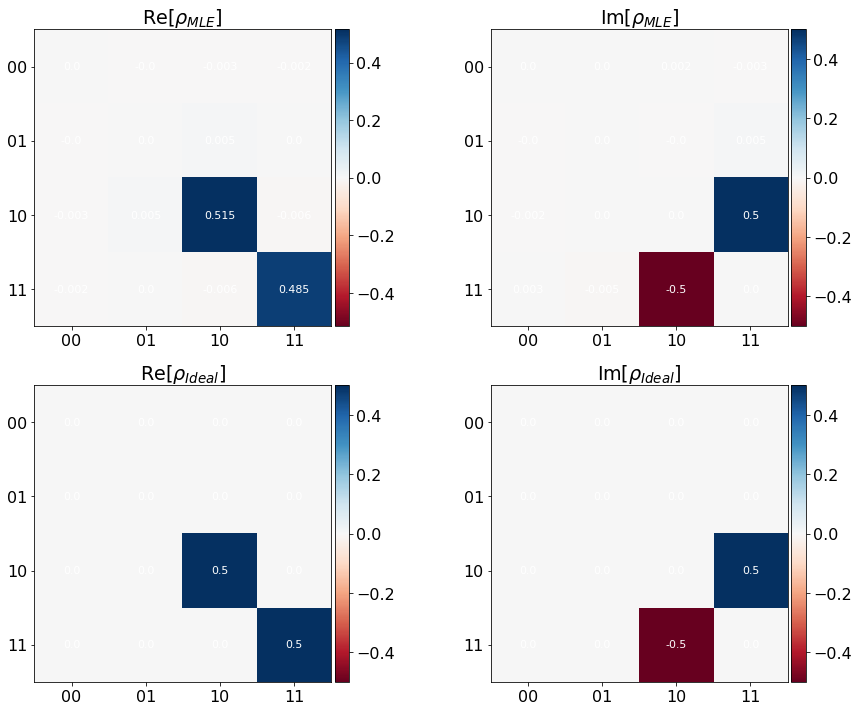

In [541]:
show_plot_rho_2d(rho_MLE_base, rho_id)